#### Process raw VR data to canonical
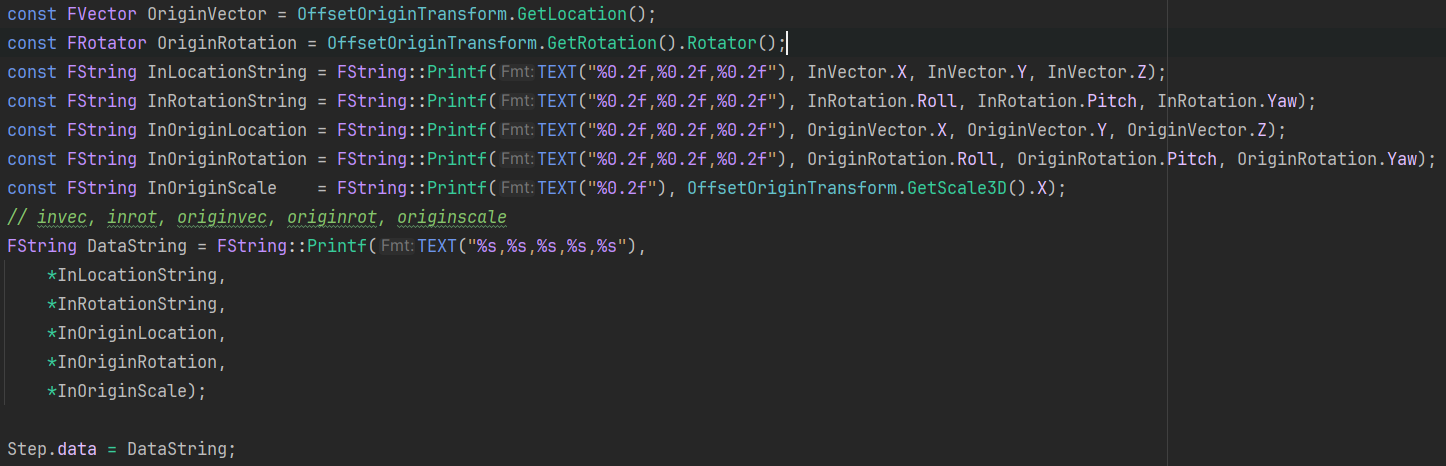

In [115]:
!pip install pandas -q

In [282]:
# Input log file
log_file = 'cellworld_vr_friday_4_4_finn_large.log'
# log_file = 'cellworld_vr_latest.log'

In [117]:
# imports 
import cellworld_game as game
import cellworld as cw
import math
import os
from cellworld_game import CoordinateConverter 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

In [273]:
import re
output_file = f"{log_file.split('.')[0]}_parsed.csv"

# Regex to extract frame number and X, Y values from lines like:
# [timestamp][thread]LogTemp: [AExperimentClient::UpdatePreyPosition] Sent frame: 2 | location: X=1324.329 Y=-237.742 Z=246.764
pattern = re.compile(r'frame:\s*(\d+)\s*\|\s*location:\s*X=([-+]?\d*\.\d+|\d+)\s*Y=([-+]?\d*\.\d+|\d+)', re.IGNORECASE)
anchor_pattern = re.compile(r'AnchorLocation([AB]):\s*X=([-+]?\d*\.\d+|\d+)\s*Y=([-+]?\d*\.\d+|\d+)', re.IGNORECASE)

# List to store extracted data
extracted_data = []

# Read the log file
with open(log_file, "r", encoding="utf-8") as file:
    content = file.read()

# Find all matches
matches = pattern.findall(content)
matches_anchor = anchor_pattern.findall(content)
# Save extracted data
with open(output_file, "w", encoding="utf-8") as out_file:
    out_file.write("Frame,X,Y\n")  # CSV Header
    for frame, x, y in matches:
        out_file.write(f"{frame},{x},{y}\n")
        extracted_data.append((frame, x, y))

# Output results
print(f"Extracted {len(extracted_data)} entries and saved to {output_file}")

Extracted 4078 entries and saved to cellworld_vr_latest_parsed.csv


In [283]:
import re
import numpy as np
# Read the file content
with open(log_file, "r") as file:
    text = file.read()

# Define a regex pattern to match the location entry
# This pattern captures the x and y values as groups
pattern = r'"location"\s*:\s*{\s*"x"\s*:\s*(-?\d+\.?\d*),\s*"y"\s*:\s*(-?\d+\.?\d*)\s*}'

# Find all matches in the text
matches = re.findall(pattern, text)

# Optionally convert string matches to floats and create dictionaries
location_vectors = [np.array([float(x), float(y)]) for x, y in matches]

print(location_vectors)

# Define a regex pattern to capture the anchor label and coordinates
pattern = r'AnchorLocation(?P<label>[AB]):\s+X=(?P<X>-?\d+\.\d+)\s+Y=(?P<Y>-?\d+\.\d+)\s+Z=(?P<Z>-?\d+\.\d+)'

# Find all matches in the text
matches = re.finditer(pattern, text)

# Create a dictionary to store the results
results = {}
for match in matches:
    label = match.group('label')
    x = float(match.group('X'))
    y = float(match.group('Y'))
    z = float(match.group('Z'))
    results[f'AnchorLocation{label}'] = {"x": x, "y": y, "z": z}

print(results)
anchor_vectors = {k: np.array([v["x"], v["y"], v["z"]]) for k, v in results.items()}
AL_A = anchor_vectors["AnchorLocationA"]
AL_B = anchor_vectors["AnchorLocationB"]

difference = AL_B - AL_A
print(anchor_vectors)

[array([2245.00634766, 2292.20336914]), array([2244.97216797, 2292.1940918 ]), array([2244.95263672, 2292.19580078]), array([2244.93383789, 2292.19873047]), array([2244.90332031, 2292.20800781]), array([2244.81762695, 2292.22729492]), array([2244.79125977, 2292.23413086]), array([2244.76049805, 2292.23803711]), array([2244.72216797, 2292.24487305]), array([2244.63964844, 2292.25537109]), array([2244.2824707 , 2292.38598633]), array([2244.2824707 , 2292.38598633]), array([2244.2824707 , 2292.38598633]), array([2244.2824707 , 2292.38598633]), array([2244.2824707 , 2292.38598633]), array([2244.2824707 , 2292.38598633]), array([2243.94042969, 2292.46533203]), array([2243.84204102, 2292.47705078]), array([2243.84204102, 2292.47705078]), array([2243.84204102, 2292.47705078]), array([2243.72998047, 2292.47265625]), array([2243.72998047, 2292.47265625]), array([2243.61035156, 2292.484375  ]), array([2243.61035156, 2292.484375  ]), array([2243.48461914, 2292.48754883]), array([2243.40063477, 22

In [275]:
# load file
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
# csv_file = output_file
csv_file = 'cellworld_vr_latest_parsed.csv'

# Read the CSV file
df = pd.read_csv(csv_file)
df.set_index(df.columns[0], inplace=True)

x_vals = df['X']
y_vals = df['Y']

if matches_anchor: 
    print(matches_anchor)
    originA_raw = [float(matches_anchor[0][1]), float(matches_anchor[0][2])]
    originB_raw = [float(matches_anchor[1][1]), float(matches_anchor[1][2])]


# diff = originA_raw - originB_raw

# print(diff)
print(originA_raw)
print(originB_raw)

df.head()

[('A', '116.002', '94.969'), ('B', '1354.902', '-230.066')]
[116.002, 94.969]
[1354.902, -230.066]


X        Y
Frame                   
0      1324.684 -236.795
1      1324.513 -237.237
2      1324.329 -237.742
3      1323.947 -238.754
4      1323.737 -239.304

#### Test VRCoordinateConverter Class

In [285]:
import cellworld_game as game
import numpy as np
import math
class VRCoordinateConverter:
    def __init__(self):
        self.origin_transform = {'direction':None, 'scale': None}
        self.origin = {'entry':None, 'exit':None}
        self.active = False
        pass
    
    def set_origin(self, originA:list=None, originB:list=None, flipY:bool=True):
        self.origin['entry'] = [originA[1], -originA[0]] # flip x/y to y/-x
        self.origin['exit']  = [originB[1], -originB[0]] # flip x/y to y/-x
        self.origin_transform['direction'] = game.Direction.radians(self.origin['entry'], self.origin['exit'])  + np.pi/2
        self.origin_transform['scale']     = game.Point.distance(self.origin['entry'] ,  self.origin['exit'])
        self.active = True
        print(f'[set origin] Active: {self.active}')
        print(f'[set origin] Origin: {self.origin}')
        print(f'[set origin] Origin Tranform: {self.origin_transform}')
    
    def vr_to_canonical_v1(self,x,y)->game.Point:
        dirp = game.Direction.radians(self.origin['entry'], (x,y)) - self.origin_transform['direction']
        distp = game.Point.distance(self.origin['entry'],(x,y)) / self.origin_transform['scale']
        return game.Point.move((0, .5), distance=distp, direction_radians=dirp)

    
    def vr_to_canonical(self,x,y)->game.Point:
        dirp = game.Direction.radians(self.origin['entry'], (x,y)) - self.origin_transform['direction']
        distp = game.Point.distance(self.origin['entry'],(x,y)) / self.origin_transform['scale'] 
        point = game.Point.move((0, .5), distance=distp, direction_radians=dirp)         
        y = point[1]*math.sqrt(3)*0.5  + 0.5 - (math.sqrt(3)/4) 
        offset = (1-math.sqrt(3)*0.5)
        magic_num = 0.0275
        point = (point[0]+magic_num, point[1] - offset - magic_num)
        return point

    def vr_to_canon(self, x,y):
        # print(self.origin['entry'][0])
        theta =-np.pi / 2  # 90 degrees in radians

# Rotation matrix for a 90° counterclockwise rotation
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta),  np.cos(theta)]])
    
        entry = np.array([self.origin['entry'][0], self.origin['entry'][1]])
        exit = np.array([self.origin['exit'][0], self.origin['exit'][1]])
        # entry = np.dot(rot_mat, entry)
        # exit = np.dot(rot_mat, exit)

        # print(entry)
        # print(exit)
        p = entry - exit
        magnitude = np.linalg.norm(p)
        radius = magnitude/2
        # print(magnitude)
        # np.array(self)
        # print(p)
        ##construct a basis
        e1 = p/magnitude
        e2 = np.array([-e1[1], e1[0]])
        centre_vertex = p/2 + entry
        half_vector = p/2
        theta = np.pi/3
        R60 = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta),  np.cos(theta)]])
        Rm60 = np.array([[np.cos(-theta), -np.sin(-theta)],
                        [np.sin(-theta),  np.cos(-theta)]])

        top_vertex = centre_vertex + np.dot(R60, half_vector)
        bottom_vertex = centre_vertex + np.dot(Rm60, half_vector)

        y_max = np.dot(top_vertex - entry, e2)
        y_min = np.dot(bottom_vertex - entry, e2)


        player_pos = np.array([x, y]) 
        theta =-np.pi / 2  # 90 degrees in radians

# Rotation matrix for a 90° counterclockwise rotation
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta),  np.cos(theta)]])


        player_relative = player_pos - entry
        # player_relative = np.matmul(rot_mat, player_relative)[0]
        print(player_relative)
        # player_relative = np.dot(rot_mat, player_relative)
        x_hex = np.dot(player_relative, e1)
        y_hex = np.dot(player_relative, e2) 
        offset = np.array([0.5, 0]) - p
        # x_hex += offset[0]
        # y_hex += offset[1]
        x_normalised = x_hex/magnitude
        y_normalised = y_hex - y_min
        y_normalised /= (y_max - y_min)
        y_normalised *= np.sqrt(3)/2
        # y_normalised = y_hex/magnitude
        normalised_p = np.array([x_normalised, y_normalised])  

        entry_x = np.dot(entry, e1)
        entry_x /= magnitude
        entry_y = np.dot(entry, e2)
        entry_y -= y_min
        entry_y /= (y_max - y_min)
        entry_y *= np.sqrt(3)/2

        print("Projected entry point: ")
        print(entry_x)
        print("\n")
        print(entry_y)
        print("\n")

        # normalised_p  += offset
        # normalised_p += np.array([0, 0.5])
        # normalised_p = np.dot(rot_mat, normalised_p)
        # normalised_p[0] += 0.5
        print("Normalised position: ")
        print(normalised_p)
        print("\n")
        # dirp = game.Direction.radians((0, 0.5), (x_normalised,y_normalised)) 
        # dist = game.Point.distance((0, 0.5), (x_normalised, y_normalised))
        # p = game.Point.move((0, 0.5), distance = dist, direction_radians= dirp)
        # print(p)
        # y = normalised_p[1]*math.sqrt(3)*0.5 + 0.5 - (math.sqrt(3)/4)
        # y += 0.5
        offset = (1 - math.sqrt(3)*0.5)
        # normalised_p[1] = y
      #  normalised_p[1] - offset
        return normalised_p




    def canonical_to_vr(self, px, py) -> game.Point:
        direction = game.Direction.radians((0, 0.5), (px, py)) + self.origin_transform['direction']
        distance = game.Point.distance((0, 0.5), (px, py)) * self.origin_transform['scale']
        return game.Point.move(self.origin['entry'], distance=distance, direction_radians=direction)  
    

In [287]:
vrcc = VRCoordinateConverter()
vrcc.set_origin(originA=AL_A, originB=AL_B)
# vrcc.vr_to_canon()
drotated_points_vcc = []
dunrotated_points_vcc = []
idx = 0

for v in zip(location_vectors):
    # theta = np.pi
    # rot_mat = np.matrix([[np.cos(theta), -np.sin(theta)]
    #                      ,[
    #            np.sin(theta), np.cos(theta)]])
    # print(v[0])
    q = v[0]
    # q[0] += 0.5
    # print(v[0].size)
    # # t = np.array([v[0], v[1]])
    # q = np.matmul(rot_mat, v[0])
    # print(np.dot(q, v[0]))
    # print(q[0, 0])
    pc = vrcc.vr_to_canon(v[0][0], v[0][1])
    drotated_points_vcc.append(pc)
drotated_points_vcc = np.array(drotated_points_vcc)
left_vertex_index = np.argmin(drotated_points_vcc[:, 0])
left_vertex_current = drotated_points_vcc[left_vertex_index]
print("Left vertex (before translation):", left_vertex_current)
offset = np.array([0, 0.5]) - left_vertex_current
adjusted_points = drotated_points_vcc

# for x, y in zip(x_vals, y_vals):
#     pc = vrcc.vr_to_canon(x, y)
#     drotated_points_vcc.append(pc)

# adjusted_points = drotated_points_vcc
# for x, y in zip(x_vals, y_vals):
#   pc = vrcc.vr_to_canonical(x, y)
# #   pc = vrcc.vr_to_canonical(x,y)
# #   pvr = vrcc.canonical_to_vr(pc[0],pc[1])
#   # print(f'xvr: {x:0.2f}, xvr->xc: {pc[0]:0.2f} | xc->xvr {pvr[0]:0.2f} | error: {x-pvr[0]:0.2f}')
#   # print(f'yvr: {y:0.2f}, yvr->xc: {pc[1]:0.2f} | yc->yvr {pvr[1]:0.2f} | error: {y-pvr[1]:0.2f}')
#   drotated_points_vcc.append(pc)
# #   dunrotated_points_vcc.append(pvr)
#   idx +=1 
# print(drotated_points_vcc)
# drotated_points_vcc = np.array(drotated_points_vcc)

[set origin] Active: True
[set origin] Origin: {'entry': [np.float64(-76.528), np.float64(-95.533)], 'exit': [np.float64(2182.818), np.float64(-2568.52)]}
[set origin] Origin Tranform: {'direction': 0.7402838320628093, 'scale': 3349.672976558309}
[2321.53434766 2387.73636914]
Projected entry point: 
-0.005645890509909731


0.46911641781955843


Normalised position: 
[ 0.05879443 -0.55945968]


[2321.50016797 2387.7270918 ]
Projected entry point: 
-0.005645890509909731


0.46911641781955843


Normalised position: 
[ 0.05879927 -0.55945028]


[2321.48063672 2387.72880078]
Projected entry point: 
-0.005645890509909731


0.46911641781955843


Normalised position: 
[ 0.05880358 -0.55944632]


[2321.46183789 2387.73173047]
Projected entry point: 
-0.005645890509909731


0.46911641781955843


Normalised position: 
[ 0.05880801 -0.55944277]


[2321.43132031 2387.74100781]
Projected entry point: 
-0.005645890509909731


0.46911641781955843


Normalised position: 
[ 0.0588162  -0.55943791]


[23

#### Plot Raw data (trajectory is entry to exit door)

[[0.         1.        ]
 [0.         0.98989899]
 [0.         0.97979798]
 [0.         0.96969697]
 [0.         0.95959596]
 [0.         0.94949495]
 [0.         0.93939394]
 [0.         0.92929293]
 [0.         0.91919192]
 [0.         0.90909091]
 [0.         0.8989899 ]
 [0.         0.88888889]
 [0.         0.87878788]
 [0.         0.86868687]
 [0.         0.85858586]
 [0.         0.84848485]
 [0.         0.83838384]
 [0.         0.82828283]
 [0.         0.81818182]
 [0.         0.80808081]
 [0.         0.7979798 ]
 [0.         0.78787879]
 [0.         0.77777778]
 [0.         0.76767677]
 [0.         0.75757576]
 [0.         0.74747475]
 [0.         0.73737374]
 [0.         0.72727273]
 [0.         0.71717172]
 [0.         0.70707071]
 [0.         0.6969697 ]
 [0.         0.68686869]
 [0.         0.67676768]
 [0.         0.66666667]
 [0.         0.65656566]
 [0.         0.64646465]
 [0.         0.63636364]
 [0.         0.62626263]
 [0.         0.61616162]
 [0.         0.60606061]


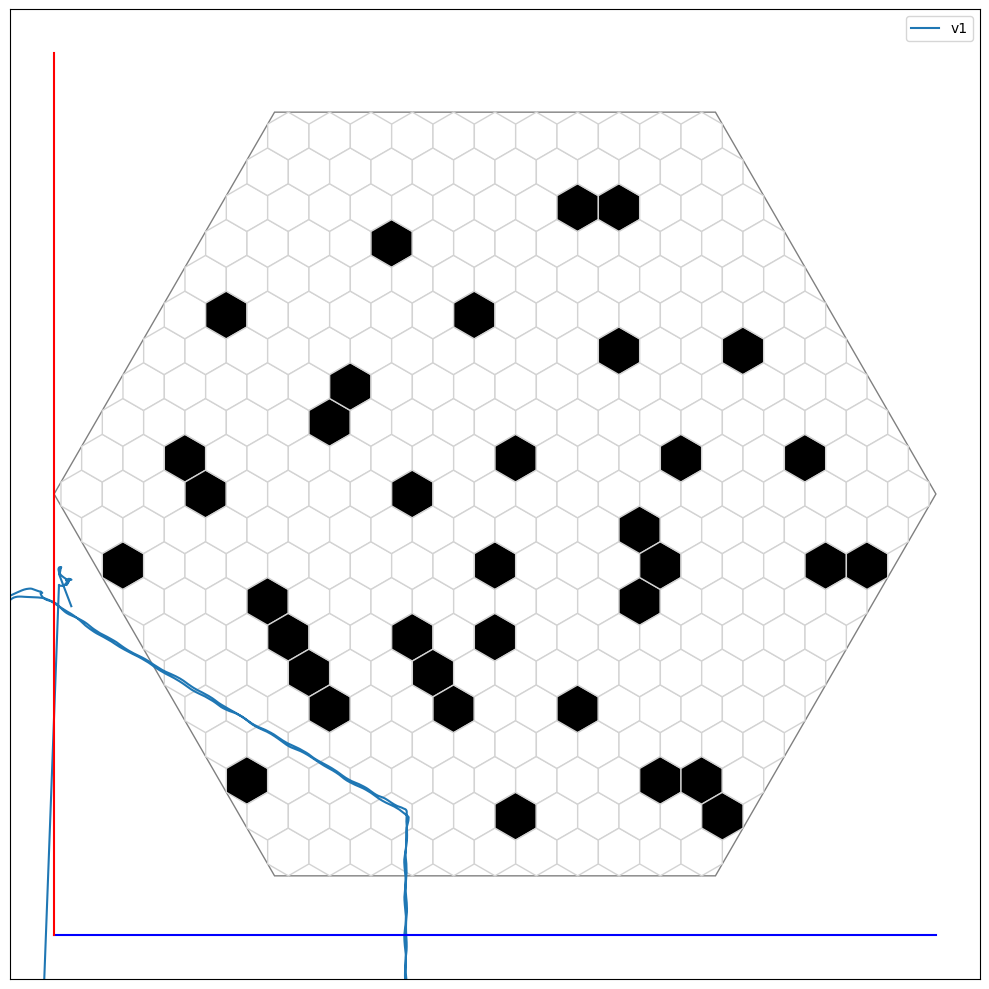

In [288]:

w = cw.World.get_from_parameters_names("hexagonal", "canonical", "21_05")
dis = cw.Display(w,fig_size=(10,10))

# plt.figure(figsize=(5,5))
# plt.plot(dunrotated_points_vcc[:, 0], dunrotated_points_vcc[:, 1], linewidth=1.5,label='v2')
drotated_points_vcc = np.array(drotated_points_vcc)
plt.plot(adjusted_points[:, 0], adjusted_points[:, 1], linewidth=1.5,label='v1')
plt.legend()
x1 = np.linspace(0, 1, 100)
y1 = np.linspace(0, 0, 100)
adjusted_points_v1 = np.column_stack((x1, y1))

# For v2: a line from (0,1) to (1,0)
x2 = np.linspace(0, 0, 100)
y2 = np.linspace(1, 0, 100)
adjusted_points_v2 = np.column_stack((x2, y2))
print(adjusted_points_v2)
# Plot the points as lines with different colors and labels
# plt.figure(figsize=(8, 6))
plt.plot(adjusted_points_v1[:, 0], adjusted_points_v1[:, 1],
         linewidth=1.5, label='v1', color='blue')
plt.plot(adjusted_points_v2[:, 0], adjusted_points_v2[:, 1],
         linewidth=1.5, label='v1', color='red')

x points: [1.    0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.8   0.775 0.75  0.7
 0.65  0.6   0.55  0.5   0.45  0.4   0.35  0.3   0.25  0.225 0.2   0.175
 0.15  0.125 0.1   0.075 0.05  0.025 0.    0.025 0.05  0.075 0.1   0.125
 0.15  0.175 0.2   0.225 0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6
 0.65  0.7   0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975
 1.   ]
y points: [0.5        0.54330127 0.58660254 0.62990381 0.67320508 0.71650635
 0.75980762 0.80310889 0.84641016 0.88971143 0.9330127  0.9330127
 0.9330127  0.9330127  0.9330127  0.9330127  0.9330127  0.9330127
 0.9330127  0.9330127  0.9330127  0.88971143 0.84641016 0.80310889
 0.75980762 0.71650635 0.67320508 0.62990381 0.58660254 0.54330127
 0.5        0.45669873 0.41339746 0.37009619 0.32679492 0.28349365
 0.24019238 0.19689111 0.15358984 0.11028857 0.0669873  0.0669873
 0.0669873  0.0669873  0.0669873  0.0669873  0.0669873  0.0669873
 0.0669873  0.0669873  0.0669873  0.11028857 0.15358984 0.19689111
 0.24019238 

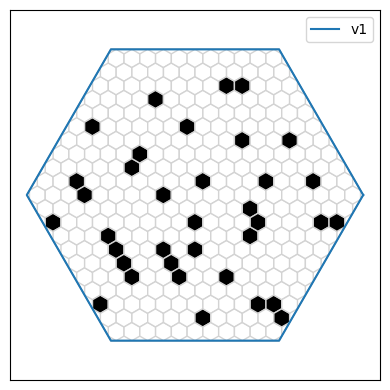

In [259]:
def hexagon_points(R, n_points_per_edge=10):
    """
    Generate points along the edges of a regular hexagon with side length R,
    with the left vertex (angle 180°) placed at the origin.
    
    The hexagon vertices (in order) are computed by:
      - Vertex 3: leftmost point at (0, 0)
      - Vertex 2: (0.5*R, sqrt(3)/2*R)
      - Vertex 1: (1.5*R, sqrt(3)/2*R)
      - Vertex 0: (2*R, 0)
      - Vertex 5: (1.5*R, -sqrt(3)/2*R)
      - Vertex 4: (0.5*R, -sqrt(3)/2*R)
    
    The vertices are defined so that walking from vertex 3 to vertex 2, then 1, 0, 5, 4, and back to 3
    forms the hexagon in counterclockwise order.
    """
    # Define the vertices of the hexagon (translated so that vertex 3 is at (0,0))
    vertices = np.array([
        [2*R, 0],                    # Vertex 0 (angle 0°)
        [1.5*R, np.sqrt(3)/2 * R],     # Vertex 1 (angle 60°)
        [0.5*R, np.sqrt(3)/2 * R],     # Vertex 2 (angle 120°)
        [0, 0],                      # Vertex 3 (angle 180°) -> left vertex at the origin
        [0.5*R, -np.sqrt(3)/2 * R],    # Vertex 4 (angle 240°)
        [1.5*R, -np.sqrt(3)/2 * R],    # Vertex 5 (angle 300°)
        [2*R, 0]                     # Close the hexagon (repeat Vertex 0)
    ])
    
    points = []
    # Loop over each consecutive pair of vertices
    for i in range(len(vertices) - 1):
        start = vertices[i]
        end = vertices[i + 1]
        # Generate points along the segment from start to end.
        # We use linspace to interpolate points (excluding the end point to avoid duplicates).
        for t in np.linspace(0, 1, n_points_per_edge, endpoint=False):
            pt = start + t * (end - start)
            points.append(pt)
    # Append the last vertex to complete the loop.
    points.append(vertices[-1])
    
    return np.array(points)

# Parameters: side length and number of points per edge
R = 1.0
points = hexagon_points(R, n_points_per_edge=10)
points *= 0.5
# Separate the points into x and y arrays
x = points[:, 0]
y = points[:, 1]
y += 0.5
print("x points:", x)
print("y points:", y)

w = cw.World.get_from_parameters_names("hexagonal", "canonical", "21_05")
dis = cw.Display(w,fig_size=(4,4))

# plt.figure(figsize=(5,5))
# plt.plot(dunrotated_points_vcc[:, 0], dunrotated_points_vcc[:, 1], linewidth=1.5,label='v2')
drotated_points_vcc = np.array(drotated_points_vcc)
plt.plot(x,y, linewidth=1.5,label='v1')
plt.legend()

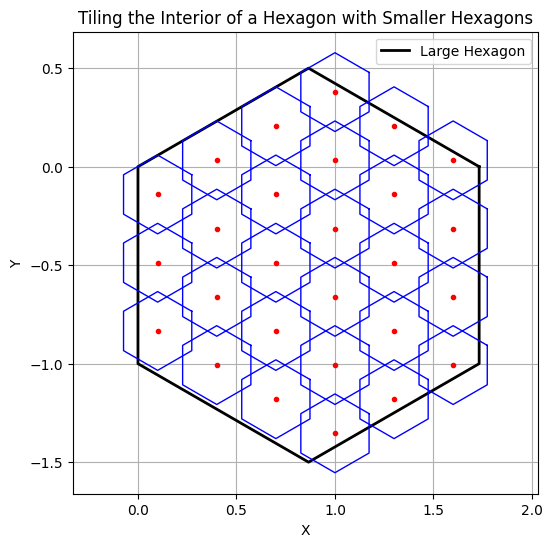

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

def generate_large_hexagon(R):
    """
    Generate vertices for a flat-topped hexagon with side length R,
    then translate it so that its leftmost vertex is at (0, 0).
    
    For a flat-topped hexagon, the vertices (centered at the origin) can be computed by:
      vertex = R * [cos(30+60*i), sin(30+60*i)] for i in 0,...,5.
    """
    angles = np.deg2rad(np.array([30, 90, 150, 210, 270, 330]))
    vertices = R * np.column_stack((np.cos(angles), np.sin(angles)))
    # Find the leftmost vertex and translate so that it becomes (0,0)
    left_idx = np.argmin(vertices[:, 0])
    translation = -vertices[left_idx]
    vertices = vertices + translation
    # Close the polygon by appending the first vertex at the end
    vertices = np.vstack([vertices, vertices[0]])
    return vertices

def generate_small_hexagon(center, a):
    """
    Generate vertices for a flat-topped hexagon with side length a,
    centered at the given coordinate.
    
    The vertices are computed with angles 30, 90, ... 330 degrees.
    """
    angles = np.deg2rad(np.array([30, 90, 150, 210, 270, 330]))
    vertices = np.array([center + a * np.array([np.cos(angle), np.sin(angle)]) for angle in angles])
    # Close the hexagon
    vertices = np.vstack([vertices, vertices[0]])
    return vertices

# Parameters
R_large = 1.0    # Side length of the large hexagon
a_small = 0.2    # Side length of the small hexagons

# Generate large hexagon vertices (with left vertex at (0,0))
large_hex = generate_large_hexagon(R_large)
large_hex_path = Path(large_hex)

# Get bounding box for the large hexagon
min_x, min_y = np.min(large_hex, axis=0)
max_x, max_y = np.max(large_hex, axis=0)

# For a flat-topped hexagon grid:
# Horizontal center spacing is 3/2 * a_small.
dx = 3/2 * a_small
# Vertical spacing is sqrt(3) * a_small.
dy = np.sqrt(3) * a_small

# Generate candidate centers over the bounding box (with some margin)
x_candidates = np.arange(min_x - a_small, max_x + a_small, dx)
y_candidates = np.arange(min_y - a_small, max_y + a_small, dy)

small_hex_centers = []
for i, x in enumerate(x_candidates):
    for j, y in enumerate(y_candidates):
        # Offset every other column for a proper hex grid (using odd-q offset)
        if i % 2 == 1:
            center = np.array([x, y + dy/2])
        else:
            center = np.array([x, y])
        # Only keep centers that lie within the large hexagon
        if large_hex_path.contains_point(center):
            small_hex_centers.append(center)
small_hex_centers = np.array(small_hex_centers)

plt.figure(figsize=(6, 6))
# Plot the large hexagon boundary
plt.plot(large_hex[:, 0], large_hex[:, 1], 'k-', lw=2, label="Large Hexagon")

# Plot each small hexagon
for center in small_hex_centers:
    small_hex = generate_small_hexagon(center, a_small)
    plt.plot(small_hex[:, 0], small_hex[:, 1], 'b-', lw=1)
    # Optionally, mark the center
    plt.plot(center[0], center[1], 'ro', markersize=3)

plt.title("Tiling the Interior of a Hexagon with Smaller Hexagons")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()